In [1]:
import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_boston
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [2]:
PICKLE_PATH = '../augmented_datasets/pickles/final_data/hopkins_conf_narrow_0605.pkl'
OUTLIER_QUARTILES = (0.02, 0.98) # Min, max quartiles

In [3]:
def remove_outlier(df, range_, columns):
    low = range_[0]
    high = range_[1]
    qnt = df.quantile([low, high])
    data = df.copy()
    for col in list(columns):
        data[col] = \
            data[(data[col] > qnt.loc[low, col]) &\
               (data[col] < qnt.loc[high, col])][col]
    return data.dropna()

def calc_corrs_scatter(df, outliers=(0,0), gdp_thr=0, urb_thr=0, only_us=False,\
                       show_names=False, show_states=False, temp_outliers=(0,0)):

    targets = ['proxy', 'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']

    for target in targets:
        print('Interval temp vs {0} correlations'.format(target))
        if outliers == (0,0):
            confs1 = df.copy()
        else:
            confs1 = remove_outlier(df, outliers, [target])
        if temp_outliers != (0,0):
            confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
        confs1.dropna(inplace=True)
        if only_us:
            confs1 = confs1[confs1['Country_Region'] == 'US']
        confs1 = confs1[confs1['GDP'] > gdp_thr]
        confs1 = confs1[confs1['Urbanization'] > urb_thr]       
        gf = confs1[target].loc[:,'data'].values.tolist()
        avg_int_tmp = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

        corr_p1 = stats.pearsonr(gf, avg_int_tmp)
        corr_s1 = stats.spearmanr(gf, avg_int_tmp)

        print('n={0}'.format(len(gf)))
        print('Pearson: {0}\tOne sided p_value: {1}'.format(corr_p1[0], corr_p1[1] / 2))
        print('Spearman: {0}\tOne sided p_value: {1}\n'.format(corr_s1[0], corr_s1[1] / 2))

    if outliers == (0,0):
        confs1 = df.copy()
    else:
        confs1 = remove_outlier(df, outliers, ['proxy'])
    if temp_outliers != (0,0):
        confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
    if only_us:
        confs1 = confs1[confs1['Country_Region'] == 'US']
    confs1 = confs1[confs1['GDP'] > gdp_thr]
    confs1 = confs1[confs1['Urbanization'] > urb_thr]       
    
    confs1.dropna(inplace=True)
    
    proxy = confs1['proxy'].loc[:,'data'].values.tolist()
    avg_int_tmp1 = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

    fig, axes = plt.subplots(figsize=(15, 7))
    _ = axes.scatter(avg_int_tmp1, proxy)
    n = len(proxy)

    _ = axes.set_xlabel('avg interval temp')
    _ = axes.set_ylabel('proxy')
    _ = axes.set_title('n={0}'.format(n))

    if show_names:
        countries1 = confs1['Country_Region'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(countries1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], proxy[i]))

    if show_states and not show_names:
        states1 = confs1['Province_State'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(states1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], proxy[i]))
            
def manual_WRS(gf_qx, df, temp_range):

    colds = df[df['avg_interval_tmp'] <= temp_range[0]]\
        [[gf_qx]]

    hots = df[df['avg_interval_tmp'] >= temp_range[1]]\
        [[gf_qx]]

    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)

    colds.rename(columns={gf_qx: ''}, inplace=True)
    hots.rename(columns={gf_qx: ''}, inplace=True)

    # manual WRS algorithm

    colds = colds.T
    hots = hots.T
    colds = colds.add_prefix('c')
    hots = hots.add_prefix('h')
    ranks = colds.join(hots, lsuffix='first').rank(axis=1)
    
    h_list = [sample for sample in ranks.columns if 'h' in sample]
    c_list = [sample for sample in ranks.columns if 'c' in sample]
    h_sum = ranks[h_list].sum(axis=1)
    c_sum = ranks[c_list].sum(axis=1)

    b = len(colds.columns)
    n = b + len(hots.columns)
    expected_cold_sum = (b * (n + 1)) / 2
    sigma = math.sqrt(b * (n - b) * (n + 1) / 12)

    sums_normal = stats.norm(loc=expected_cold_sum, scale=sigma)
    p_value = 1 - sums_normal.cdf(float(c_sum))
    
    size = {
           'colds': b,
           'hots': len(hots.columns)
           }
    
    return {'expected': expected_cold_sum, 
            'attained': c_sum, 
            'p': p_value, 
            'sigma': sigma, 
            'size': size}

def print_manual_WRS(qx, qx_results):
    difference = qx_results[1] - qx_results[0]
    print('--------------------------------------------------')
    print('{} WRS (manual)'.format(qx))
    print('--------------------------------------------------')
    print(
         '# colds samples: {0}\n# of hots samples: {1}\n'
         'Expected mean for cold countries rank sum: {2}\n'
         'Attained mean for cold countries rank sum: {3}\n'
         'Sigma: {4}\n'
         '(Attained mean) - (Expected mean) = {5}\n'
         'p-value for this result is: {6}'
         .format(qx_results[4]['colds'], qx_results[4]['hots'], qx_results[0],\
                 qx_results[1], difference, qx_results[3], qx_results[2]))

def builtin_WRS(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ranksums(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}

def print_builtin_WRS(qx, qx_results):
    print('--------------------------------------------------')
    print('{} WRS (built-in) '.format(qx))
    print('--------------------------------------------------')
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
#     print('--------------------------------------------------')


def builtin_ttest(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ttest_ind(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}


def print_builtin_ttest(qx, qx_results):
    print('--------------------------------------------------')
    print('{} TTest (built-in)'.format(qx))
    print('--------------------------------------------------')
    print('# colds: {0}\n# of hots: {1}'.format(qx_results[2]['colds'], qx_results[2]['hots']))
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
    print('--------------------------------------------------')

def calc_wrs_ttest(df, temp_range):
    Q1_manual = manual_WRS('GF_Q1', df, temp_range)
    print_manual_WRS('Q1', Q1_manual)

    Q1_builtin = builtin_WRS('GF_Q1', df, temp_range)
    print_builtin_WRS('Q1', Q1_builtin)
    
    Q1_ttest = builtin_ttest('GF_Q1', df, temp_range)
    print_builtin_ttest('Q1', Q1_ttest)
    
#     Q3_manual = manual_WRS('GF_Q3', df)
#     print_manual_WRS('Q3', Q3_manual)

#     Q3_builtin = builtin_WRS('GF_Q3', df)
#     print_builtin_WRS('Q3', Q3_builtin)

#     Q3_ttest = builtin_ttest('GF_Q3', df)
#     print_builtin_ttest('Q3', Q3_ttest)     

In [4]:
hopkins_confirmed = pd.read_pickle(PICKLE_PATH)
# these are unique to US and will cause problems here
hopkins_confirmed.drop(columns=['State Population', 'Total Tests', 'Tests \ Pop'], inplace=True)
hopkins_confirmed.dropna(inplace=True)

In [5]:
hopkins_confirmed.insert(2, 'proxy', np.nan)

In [30]:
hopkins_confirmed['proxy'] = ( (10**10) * hopkins_confirmed['GF_Q1']) / \
                             ((hopkins_confirmed['Median Age']) * hopkins_confirmed['Gini Index']\
                              * hopkins_confirmed['Democracy'] * (hopkins_confirmed['Tests per 1M']))

In [31]:
len(hopkins_confirmed[hopkins_confirmed['proxy'] > 0])
len(hopkins_confirmed[hopkins_confirmed['GF_Q3'] > 0])
hopkins_confirmed.iloc[0:100][['proxy','GF_Q1']]
hopkins_confirmed['proxy'].max()


954

1810

,,proxy,GF_Q1
coordinate,information,,
"(-41.4545, 145.9707)",data,0.200960,0.009500
"(-40.9006, 174.886)",data,0.753916,0.044525
"(-38.4161, -63.6167)",data,14.871778,0.030650
"(-37.8136, 144.9631)",data,0.506630,0.023950
"(-35.6751, -71.543)",data,1.875610,0.043700
...,...,...,...
"(21.45803166, -157.97121819999995)",data,0.149259,0.006800
"(21.9162, 95.956)",data,0.000000,0.000000
"(22.0, -80.0)",data,11.470408,0.040500


1688.4292878662818

In [22]:
PLAIN = {'df': hopkins_confirmed,
        'show_names': True
        }

OUTLIERS = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98)
            }

GDP_URB1 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 30000,
            'urb_thr': 80
            }

GDP_URB2 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 36000,
            'urb_thr': 84
            }

GDP_URB3 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 43000,
            'urb_thr': 88
            }

US_ONLY = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'only_us': True,
            'show_states': True
            }

TEMP_OUTLIERS = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'temp_outliers': (0.1, 0.9)
            }

In [6]:
hopkins_confirmed.describe()
us_states = len(hopkins_confirmed[hopkins_confirmed['Country_Region'] == 'US'])
print('Of which {0} are US locations'.format(us_states))

,GDP,Urbanization,Median Age,Gini Index,Tests per 1M,avg_mobility,avg_interval_RH,avg_interval_tmp,avg_m_tmp,avg_m_RH,...,4/27/2020,4/28/2020,4/29/2020,4/30/2020,5/1/2020,5/2/2020,5/3/2020,5/4/2020,5/5/2020,5/6/2020
count,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,...,1831.000000,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03,1.831000e+03
mean,53059.198572,72.964088,37.525232,40.924370,34286.419740,16.894438,66.214799,13.731633,10.393897,70.019756,...,2182.135991,2.235575e+03,2.291415e+03,2.353743e+03,2.418864e+03,2.479758e+03,2.536526e+03,2.590315e+03,2.646642e+03,2.710408e+03
std,18019.487777,13.812381,3.830516,2.610937,9368.695022,3.558932,9.391703,6.153905,6.656866,8.283660,...,25737.817125,2.633373e+04,2.698402e+04,2.769574e+04,2.849753e+04,2.920996e+04,2.983490e+04,3.039226e+04,3.099278e+04,3.162885e+04
min,314.544166,14.338000,15.100000,24.200000,92.000000,3.000000,9.058824,-9.926087,-11.515094,10.981132,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,46954.000000,66.100000,36.500000,41.400000,35539.000000,14.515764,63.028175,9.198516,5.414704,66.955320,...,33.000000,3.400000e+01,3.500000e+01,3.700000e+01,3.800000e+01,3.900000e+01,4.000000e+01,4.100000e+01,4.300000e+01,4.400000e+01
50%,55172.000000,74.600000,38.100000,41.400000,35539.000000,16.500000,67.684211,13.441379,9.985849,71.622642,...,85.000000,8.700000e+01,9.000000e+01,9.500000e+01,9.800000e+01,1.000000e+02,1.050000e+02,1.070000e+02,1.090000e+02,1.110000e+02
75%,61594.000000,84.700000,39.200000,41.400000,35539.000000,18.195652,71.625626,17.670616,14.521698,74.876179,...,310.500000,3.200000e+02,3.320000e+02,3.480000e+02,3.645000e+02,3.750000e+02,3.870000e+02,3.955000e+02,4.105000e+02,4.220000e+02
max,200277.000000,100.000000,53.100000,63.000000,166416.000000,39.428571,93.864865,35.573077,31.886792,89.179245,...,988197.000000,1.012582e+06,1.039909e+06,1.069424e+06,1.103461e+06,1.132539e+06,1.158040e+06,1.180375e+06,1.204351e+06,1.228603e+06


Of which 1610 are US locations


###### CORRELATIONS AND SCATTER PLOTS PER GF
Even after screening for place where confirmed cases > 20 we still get episodes where GF_Q1 or GF_Q3 equals zero
For this reason we remove the outliers and compute correlations for each GF seperatly

GDP and URB refference :
* MEAN   - 22914, 67
* USA    - 62794, 82
* ISRAEL - 41715, 92
* FRANCE - 41463, 80

AVG_INT_TEMP refference :
* MEAN   - 12.75
* Q1     - 6.83
* Q3.    - 17.91

###### No filters - all data

Interval temp vs proxy correlations
n=1819
Pearson: 0.16993179437832273	One sided p_value: 1.4857029601090437e-13
Spearman: 0.01392679788342151	One sided p_value: 0.27639160026624565

Interval temp vs GF_Q1 correlations
n=1819
Pearson: 0.025248608773748776	One sided p_value: 0.14090150796339018
Spearman: -0.01847696470942997	One sided p_value: 0.21547612490979223

Interval temp vs GF_Q2 correlations
n=1819
Pearson: 0.034512920268104263	One sided p_value: 0.07059237382064491
Spearman: 0.006132600673414536	One sided p_value: 0.3969011024697917

Interval temp vs GF_Q3 correlations
n=1819
Pearson: 0.006933605015067707	One sided p_value: 0.38379959883144854
Spearman: -0.006245869784585474	One sided p_value: 0.39504098192096415

Interval temp vs first_7 correlations
n=1819
Pearson: -0.03606338183781053	One sided p_value: 0.06208098526249154
Spearman: -0.03969747679589256	One sided p_value: 0.04526674471497596



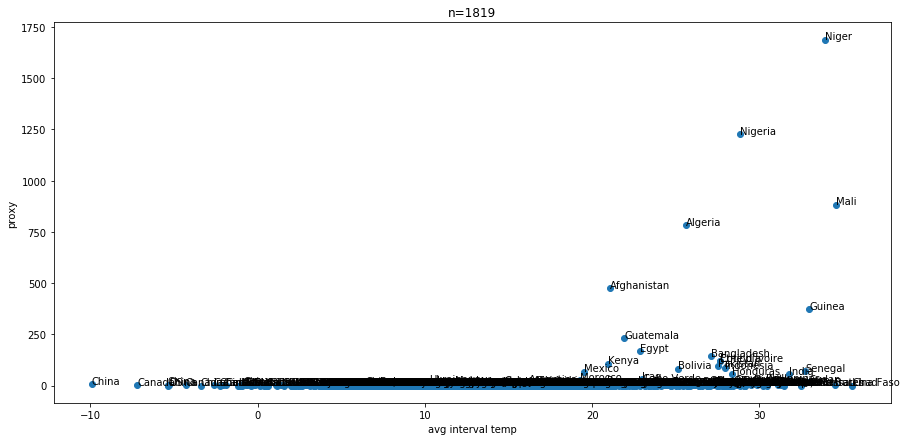

In [32]:
calc_corrs_scatter(**PLAIN)

###### No outliers - 0.02, 0.98

Interval temp vs proxy correlations
n=917
Pearson: 0.15633512874668076	One sided p_value: 9.826372948023605e-07
Spearman: -0.08444265170204177	One sided p_value: 0.0052611498871467524

Interval temp vs GF_Q1 correlations
n=917
Pearson: -0.07073671135121813	One sided p_value: 0.016104334795085815
Spearman: -0.13095117672506862	One sided p_value: 3.486667206247696e-05

Interval temp vs GF_Q2 correlations
n=1419
Pearson: -0.0343336326114325	One sided p_value: 0.09807885816216608
Spearman: -0.05858752199743127	One sided p_value: 0.013659810796962423

Interval temp vs GF_Q3 correlations
n=1745
Pearson: -0.030849716005412215	One sided p_value: 0.09886003295125986
Spearman: -0.022760788084009265	One sided p_value: 0.17099702006947215

Interval temp vs first_7 correlations
n=1725
Pearson: -0.06544771783223373	One sided p_value: 0.003272069501812845
Spearman: -0.049637903069140954	One sided p_value: 0.019632767718827396



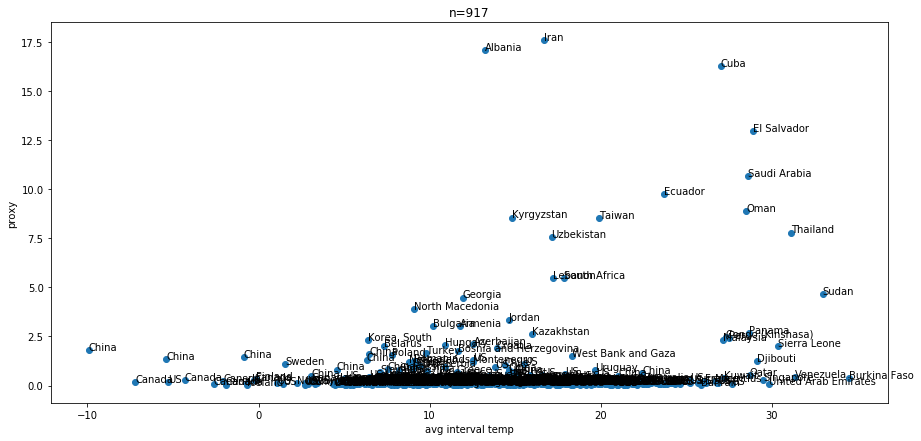

In [24]:
calc_corrs_scatter(**OUTLIERS, show_names=True)

###### GDP 30K, URB 80

Interval temp vs proxy correlations
n=315
Pearson: -0.10459136051445754	One sided p_value: 0.03186809455556782
Spearman: -0.09331405739550798	One sided p_value: 0.04914660386553349

Interval temp vs GF_Q1 correlations
n=311
Pearson: -0.09494008533261737	One sided p_value: 0.04732906200018102
Spearman: -0.11874831760115984	One sided p_value: 0.018168854044808603

Interval temp vs GF_Q2 correlations
n=432
Pearson: -0.054399155985646874	One sided p_value: 0.12961249166189892
Spearman: -0.05888089614515662	One sided p_value: 0.11098046657747392

Interval temp vs GF_Q3 correlations
n=504
Pearson: -0.014868228983736766	One sided p_value: 0.3695744943208067
Spearman: -0.004803486583620704	One sided p_value: 0.4571680542770046

Interval temp vs first_7 correlations
n=507
Pearson: 0.07444150430052436	One sided p_value: 0.0470298775056947
Spearman: 0.07029156019245167	One sided p_value: 0.05696413677697659



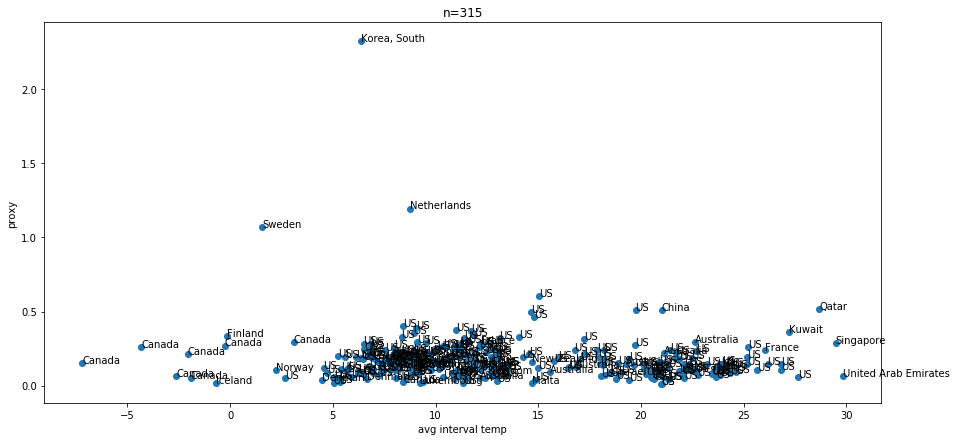

In [25]:
calc_corrs_scatter(**GDP_URB1, show_names=True)

###### GDP 36K, URB 84

Interval temp vs proxy correlations
n=287
Pearson: -0.11991354650602545	One sided p_value: 0.021181884485000003
Spearman: -0.10625076460672021	One sided p_value: 0.03614898116121085

Interval temp vs GF_Q1 correlations
n=283
Pearson: -0.1300166828236657	One sided p_value: 0.014377502980352558
Spearman: -0.1307208609795054	One sided p_value: 0.01394694635292515

Interval temp vs GF_Q2 correlations
n=392
Pearson: -0.05281710562768553	One sided p_value: 0.14844773009590187
Spearman: -0.0629544196428519	One sided p_value: 0.10680731225638955

Interval temp vs GF_Q3 correlations
n=457
Pearson: 0.0025568210732810027	One sided p_value: 0.478264823770075
Spearman: 0.005858471685977444	One sided p_value: 0.45030219030326135

Interval temp vs first_7 correlations
n=457
Pearson: 0.10328368366813355	One sided p_value: 0.013628635572551962
Spearman: 0.08466267399091051	One sided p_value: 0.03528985955771599



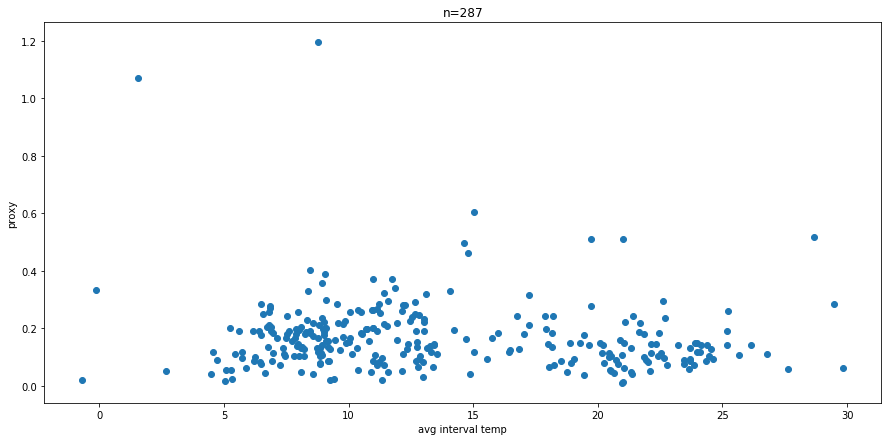

In [26]:
calc_corrs_scatter(**GDP_URB2)

###### GDP 43K, URB 88

Interval temp vs proxy correlations
n=155
Pearson: -0.15405245484806473	One sided p_value: 0.027819443991533285
Spearman: -0.2611100682464096	One sided p_value: 0.0005161002139223538

Interval temp vs GF_Q1 correlations
n=152
Pearson: -0.26995798381522795	One sided p_value: 0.00038485787082760827
Spearman: -0.30477401144823585	One sided p_value: 6.734470706059787e-05

Interval temp vs GF_Q2 correlations
n=196
Pearson: -0.2189965309822129	One sided p_value: 0.001021659450505623
Spearman: -0.2904068325516258	One sided p_value: 1.8214941292475624e-05

Interval temp vs GF_Q3 correlations
n=218
Pearson: -0.14394408965648753	One sided p_value: 0.01682817623985915
Spearman: -0.15853205101253515	One sided p_value: 0.00958852734206602

Interval temp vs first_7 correlations
n=220
Pearson: 0.025109362313340645	One sided p_value: 0.3555538615933884
Spearman: 0.03337324343067109	One sided p_value: 0.31124570218881653



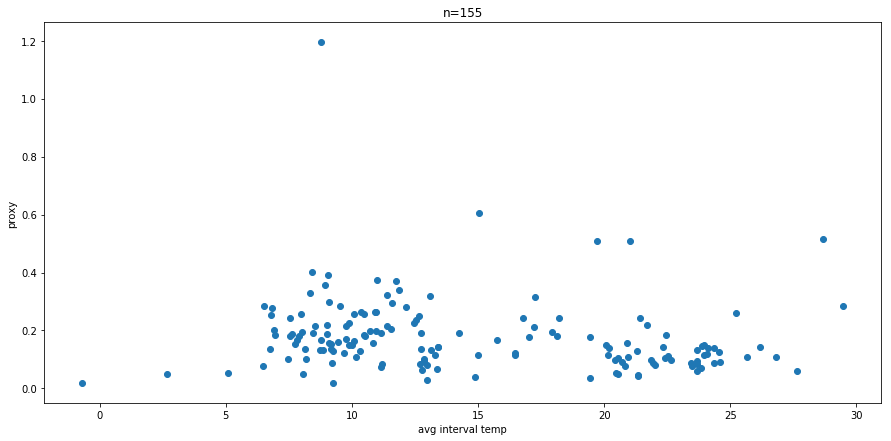

In [27]:
calc_corrs_scatter(**GDP_URB3)

###### US only

Interval temp vs proxy correlations
n=452
Pearson: -0.17755009066872582	One sided p_value: 7.396940803560069e-05
Spearman: -0.19409054455815222	One sided p_value: 1.6295104575782413e-05

Interval temp vs GF_Q1 correlations
n=86
Pearson: -0.18019487271169396	One sided p_value: 0.04843450628587171
Spearman: -0.10316247299809088	One sided p_value: 0.17227451689247258

Interval temp vs GF_Q2 correlations
n=202
Pearson: -0.09056908276912737	One sided p_value: 0.09994301162793211
Spearman: -0.05923909959620273	One sided p_value: 0.20116797941448594

Interval temp vs GF_Q3 correlations
n=447
Pearson: -0.0843878497972717	One sided p_value: 0.037346559540194675
Spearman: -0.11096989668923447	One sided p_value: 0.009466431640528425

Interval temp vs first_7 correlations
n=550
Pearson: 0.07009995165678214	One sided p_value: 0.05026702311766936
Spearman: 0.04812128455953373	One sided p_value: 0.1299496101064293



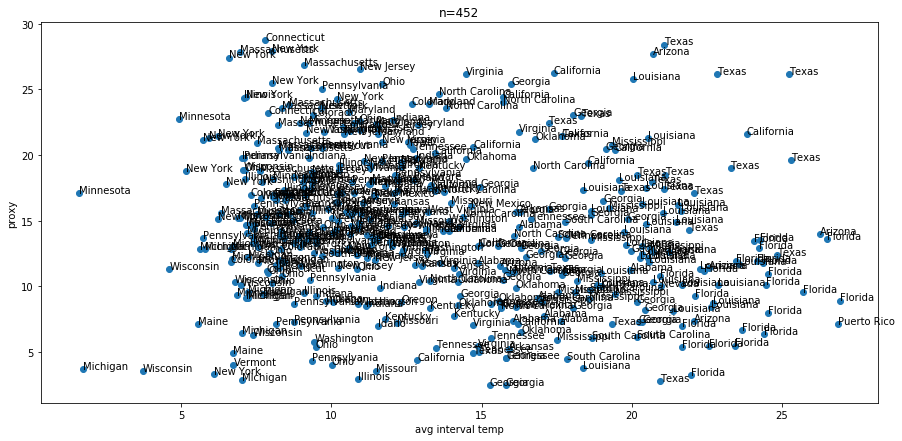

In [54]:
calc_corrs_scatter(**US_ONLY)

###### TEMP OUTLIERS 0.1, 0.9

Interval temp vs proxy correlations
n=433
Pearson: -0.20313453251893585	One sided p_value: 1.0256881009107893e-05
Spearman: -0.22109529660735222	One sided p_value: 1.7003500525305773e-06

Interval temp vs GF_Q1 correlations
n=106
Pearson: -0.09973648857641258	One sided p_value: 0.15452590079455342
Spearman: -0.01660087614340968	One sided p_value: 0.43293703507956366

Interval temp vs GF_Q2 correlations
n=208
Pearson: -0.0651859220604518	One sided p_value: 0.17477702837248477
Spearman: -0.012203420122194589	One sided p_value: 0.43056098837812706

Interval temp vs GF_Q3 correlations
n=431
Pearson: -0.17080479357611525	One sided p_value: 0.0001840830204609458
Spearman: -0.1890310955639398	One sided p_value: 3.929716730045595e-05

Interval temp vs first_7 correlations
n=524
Pearson: 0.0005874536775284298	One sided p_value: 0.4946482236027414
Spearman: -0.024875882583031184	One sided p_value: 0.284962137106326



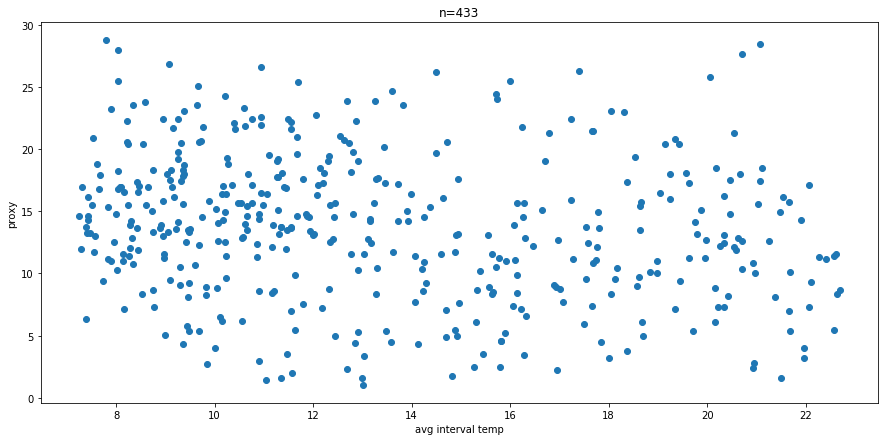

In [55]:
calc_corrs_scatter(**TEMP_OUTLIERS)

###### Rank sum
We regard two groups - 'cold' and 'hot' groups.
Each group's score is it's Q3 infection rate.
We will perform a Wilcoxon rank test and get a p-value for this arrangment

In [15]:
col = ['GF_Q1']
range_=(0.02,0.98)
gdp_th = 43000
urban_th = 88
# temp_range = (hopkins_confirmed['avg_interval_tmp'].quantile(0.1),\
#          hopkins_confirmed['avg_interval_tmp'].quantile(0.9))
temp_range = (13, 13.1)

hopkins_gdp_urban_th = hopkins_confirmed[hopkins_confirmed['GDP'] >= gdp_th].copy()
hopkins_gdp_urban_th = hopkins_gdp_urban_th[hopkins_gdp_urban_th['Urbanization'] >= urban_th].copy()
hopkins_without_outliers = remove_outlier(hopkins_confirmed, range_, [col])
hopkins_without_outliers.dropna(inplace=True)
len(hopkins_without_outliers)

923

In [16]:
arrays = [['With Outliers', 'With Outliers', 'No Outliers', 'No Outliers'],\

          ['No TH','GDP and URBAN TH', \
           'No TH','GDP and URBAN TH']]

idx = pd.MultiIndex.from_arrays(arrays, names=('Outliers', 'Thresholds'))

stats_rslt = pd.DataFrame(index=idx)

arrays_2 = [['Info on Distribution', 'Info on Distribution', 'Info on Distribution', 'WRS - manual', 'WRS - manual', 'WRS - builtin', 'WRS - builtin', 'TTest - builtin', 'TTest - builtin'], \
            ['Expected Mean', 'Attained Mean', 'Sigma', '(Expected - Attained)', 'p value', 't statistic', 'p value', 't statistic', 'p value']]
stats_rslt = stats_rslt.reindex(arrays_2, axis = 1)

stats_rslt

Info on Distribution                      \
                                      Expected Mean Attained Mean Sigma   
Outliers      Thresholds                                                  
With Outliers No TH                             NaN           NaN   NaN   
              GDP and URBAN TH                  NaN           NaN   NaN   
No Outliers   No TH                             NaN           NaN   NaN   
              GDP and URBAN TH                  NaN           NaN   NaN   

                                        WRS - manual         WRS - builtin  \
                               (Expected - Attained) p value   t statistic   
Outliers      Thresholds                                                     
With Outliers No TH                              NaN     NaN           NaN   
              GDP and URBAN TH                   NaN     NaN           NaN   
No Outliers   No TH                              NaN     NaN           NaN   
              GDP and URBAN TH                   NaN     NaN           NaN   

                                       TTest - builtin          
                               p value     t statistic p value  
Outliers      Thresholds                                        
With Outliers No TH                NaN             NaN     NaN  
              GDP and URBAN TH     NaN             NaN     NaN  
No Outliers   No TH                NaN             NaN     NaN  
              GDP and URBAN TH     NaN             NaN     NaN

In [17]:
hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])


NO_OUT = 'No Outliers'
WITH_OUT = 'With Outliers'
NO_TH = 'No TH'
WITH_TH = 'GDP and URBAN TH'


df_dict = {
    'no_outliers_no_th': {
        'df': hopkins_confirmed,
        'out': NO_OUT,
        'th': NO_TH
    },
    'no_outliers_urban_gdp_th': {
        'df': hopkins_gdp_urban_th,
        'out': NO_OUT,
        'th': WITH_TH
    },
    'with_outliers_no_th': {
        'df': hopkins_without_outliers,
        'out': WITH_OUT,
        'th': NO_TH
    },
    'with_outliers_urban_gdp_th':  {
        'df': hopkins_gdp_urban_th_no_outliers,
        'out': WITH_OUT,
        'th': WITH_TH
    }
}

for key in df_dict:
    df = df_dict[key]['df']
    out = df_dict[key]['out']
    th = df_dict[key]['th']

    result = manual_WRS('GF_Q1', df, temp_range)
    stats_rslt.loc[(out, th),('Info on Distribution', 'Expected Mean')] = result['expected']
    stats_rslt.loc[(out, th),('Info on Distribution', 'Attained Mean')] = float(result['attained'])
    stats_rslt.loc[(out, th),('Info on Distribution', 'Sigma')] = int(result['sigma'])
    stats_rslt.loc[(out, th),('WRS - manual', '(Expected - Attained)')] = float(result['attained']) - float(result['expected'])
    stats_rslt.loc[(out, th),('WRS - manual', 'p value')] = float(result['p'])
    
    result = builtin_WRS('GF_Q1', df, temp_range)
    stats_rslt.loc[(out, th),('WRS - builtin', 't statistic')] = float(result['t'])
    stats_rslt.loc[(out, th),('WRS - builtin', 'p value')] = float(result['p'])
    
    result = builtin_ttest('GF_Q1', df, temp_range)
    stats_rslt.loc[(out, th),('TTest - builtin', 't statistic')] = float(result['t'])
    stats_rslt.loc[(out, th),('TTest - builtin', 'p value')] = float(result['p'])

stats_rslt

Info on Distribution                         \
                                      Expected Mean Attained Mean    Sigma   
Outliers      Thresholds                                                     
With Outliers No TH                        210910.0      230998.5   4003.0   
              GDP and URBAN TH               7200.0        8378.5    287.0   
No Outliers   No TH                        788970.0      822178.0  11188.0   
              GDP and URBAN TH              15080.0       16350.5    503.0   

                                        WRS - manual                \
                               (Expected - Attained)       p value   
Outliers      Thresholds                                             
With Outliers No TH                          20088.5  2.616663e-07   
              GDP and URBAN TH                1178.5  2.105649e-05   
No Outliers   No TH                          33208.0  1.498531e-03   
              GDP and URBAN TH                1270.5  5.839895e-03   

                               WRS - builtin               TTest - builtin  \
                                 t statistic       p value     t statistic   
Outliers      Thresholds                                                     
With Outliers No TH                 5.017555  5.233327e-07        4.409865   
              GDP and URBAN TH      4.095571  4.211298e-05        3.859823   
No Outliers   No TH                 2.968039  2.997061e-03        2.353155   
              GDP and URBAN TH      2.521674  1.167979e-02        2.119297   

                                          
                                 p value  
Outliers      Thresholds                  
With Outliers No TH             0.000012  
              GDP and URBAN TH  0.000165  
No Outliers   No TH             0.018721  
              GDP and URBAN TH  0.035142

In [18]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_without_outliers, temp_range)




--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHOUT OUTLIERS
--------------------------------------------------


KeyError: 1

In [19]:
hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])

print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th_no_outliers, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS
--------------------------------------------------


KeyError: 1

Text(0.5,0,'Average Interval Temperature')

Text(0,0.5,'Growth Factor')

NameError: name 'n' is not defined

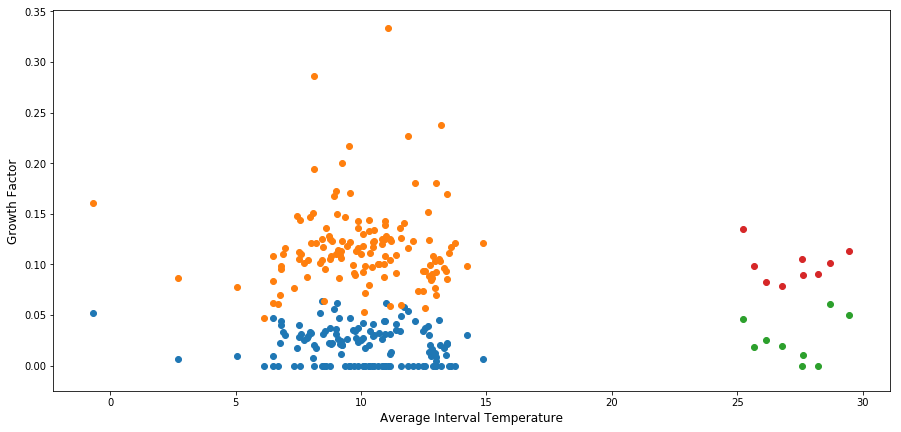

In [20]:
colds = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] <= 15][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
# print(colds.head())
colds = colds[colds['GDP'] > gdp_th]
colds = colds[colds['Urbanization'] > urban_th]


hots = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] >= 25][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['GDP'] >= gdp_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['Urbanization'] >= urban_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]


colds.reset_index(level=[0,1], drop=True, inplace=True)
hots.reset_index(level=[0,1], drop=True, inplace=True)

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q1'])
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q3'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q1'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITH OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')
# axes.text(7,  1.5556, 'Nebraska', fontsize='large')
# axes.text(9,  1.8571, 'Iowa', fontsize='large')
# plt.text(2,4,'This text starts at point (2,4)')

# without outliers
colds_no_outliers = remove_outlier(colds,range_, [col])
hots_no_outliers = remove_outlier(hots,range_, [col])

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q1'])
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q3'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q1'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITHOUT OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')

In [25]:
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_confirmed, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITH OUTLIERS
--------------------------------------------------


TypeError: calc_wrs_ttest() missing 1 required positional argument: 'temp_range'

In [20]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 7371.0
Attained mean for cold countries rank sum:     7550.0
dtype: float64
Sigma: 99.13626985114983
(Attained mean) - (Expected mean) =     179.0
dtype: float64
p-value for this result is: 0.03549077520164401
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic:	1.8055954724619272
p-value:	0.035490775201643975
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic:	1.793167043226482
p-value:	0.03770182014580103
------------------------------------------------